# Introduction
# Materials and Methods

In [1]:
%load_ext autoreload
%autoreload 2
from pylab import rcParams
from dask import delayed, compute
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
rcParams['figure.figsize'] = 10, 10
root = '/home/bzr0014/Additive/'

In [2]:
from additive2.utility import min_max_scale

In [3]:
import joblib
ultra_trimmed_high_res = joblib.load("../data/Additive/xyz_trimmed_high_res.np")
scaled_super_hi_res = joblib.load("../data/Additive/scaled_super_high_res_2x.np")

In [4]:
def make_low_res(img, s_noise, g_kern):
    if g_kern is not None:
        img = cv2.GaussianBlur(img, g_kern, 2)
    non_zero_pixels = img > 0 #assume non-negative
    non_zero_vals = img[non_zero_pixels]
    if len(non_zero_vals) == 0:
        return img
    mean, std = non_zero_vals.mean(), non_zero_vals.std()
    out = (img - mean) / std
    rnd = np.random.rand(*non_zero_vals.shape) * s_noise
    out[non_zero_pixels] += rnd
    return out

def equalize_hist(x):
    out = cv2.equalizeHist(
        min_max_scale(x, 0, 255, 'uint8')
    )
    return out

In [5]:
high_res = [delayed(make_low_res)(x, s_noise=3, g_kern=(7, 7)) for x in scaled_super_hi_res]
high_res = [delayed(equalize_hist)(x) for x in high_res]
high_res = compute(high_res)[0]
high_res = np.array(high_res)

In [6]:
predicted = [delayed(make_low_res)(x, s_noise=4, g_kern=None) for x in scaled_super_hi_res]
predicted = np.array(compute(predicted)[0])

# Results

In [210]:
from IPython.display import clear_output
import time
layer_num = 72
for layer_num in range(0, 200):
    try:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))
        axes[0].imshow(high_res[layer_num])
        axes[1].imshow(scaled_super_hi_res[layer_num])
        axes[0].set_title(layer_num)
        plt.show()
        clear_output(True)
        time.sleep(.4)
    except KeyboardInterrupt:
        res = input("Continue?")
        if res.lower().strip() != 'y':
            break
clear_output()

## Super-resolution

In [1259]:
fig, axes = plt.subplots(1, 3, figsize=(18, 9))
layer_num = 184
axes[0].imshow(high_res[layer_num])
axes[0].set_title('Mid-resolution')

axes[1].imshow(predicted[layer_num])
axes[1].set_title('Improved Resolution by Model')

axes[2].imshow(scaled_super_hi_res[layer_num])
axes[2].set_title('Corresponding High-resolution')

for ax in axes:
    ax.axis('off')

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
layer_num = 184
axes[0].imshow(high_res[layer_num])
axes[0].set_title('Mid-resolution')

axes[1].imshow(predicted[layer_num])
axes[1].set_title('Improved Resolution by Model')

Text(0.5, 1.0, 'Improved Resolution by Model')

In [9]:
# MSE between predicted and original:
np.sqrt(np.mean((min_max_scale(predicted) - min_max_scale(scaled_super_hi_res))**2))

16.515305

## Porosity 

### Finding Pores

In [10]:
from additive2.utility import find_pores_2, get_circle_mask, make_mean_kernel

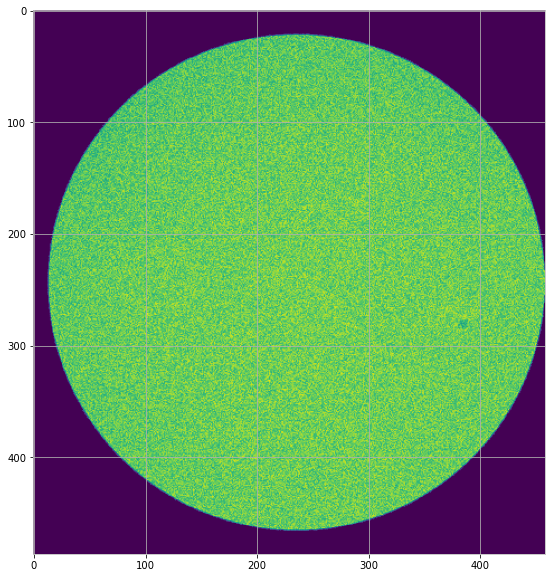

In [11]:
predicted_img = predicted[184]
mask = get_circle_mask(predicted_img, erode_kernel=np.ones((7, 7)))
predicted_pore_img = find_pores_2(predicted_img, mask, 31, 8e-5)
plt.imshow(predicted_pore_img)
plt.show()
plt.imshow(predicted_img)

In [1241]:
N = 184
high_res_img = high_res[N]
mask = get_circle_mask(high_res_img, erode_kernel=np.ones((7, 7)))
high_res_pore_img = find_pores_2(high_res_img, mask, 31, 8e-5)


predicted_img = predicted[N]
mask = get_circle_mask(predicted_img, erode_kernel=np.ones((7, 7)))
predicted_pore_img = find_pores_2(predicted_img, mask, 31, 8e-5)

scaled_img = scaled_super_hi_res[N]
mask = get_circle_mask(scaled_img, erode_kernel=np.ones((7, 7)))
scaled_pore_img = find_pores_2(scaled_img, mask, 31, 8e-5)


fig, axes = plt.subplots(2, 3, figsize=(21, 14))
fig.tight_layout(pad=0, h_pad=0, w_pad=0)

axes[0, 0].imshow(high_res_img)
axes[0, 0].set_title('Mid-resolution')

axes[1, 0].imshow(high_res_pore_img)
axes[1, 0].set_title('Pores detected from mid-resolution')

axes[0, 1].imshow(predicted_img)
axes[0, 1].set_title('Improved Resolution by Model')

axes[1, 1].imshow(predicted_pore_img)
axes[1, 1].set_title('Pored detected from improved Resolution by Model')

axes[0, 2].imshow(scaled_img)
axes[0, 2].set_title('Original High resolution')

axes[1, 2].imshow(scaled_pore_img)
axes[1, 2].set_title('Pores detected from high resolution')


for ax in axes.reshape(-1):
    ax.axis('off')

In [13]:
N = 34
high_res_img = high_res[N]
mask = get_circle_mask(high_res_img, erode_kernel=np.ones((7, 7)))
high_res_pore_img = find_pores_2(high_res_img, mask, 31, 8e-5, dilate_kernel=np.ones((2, 2)))


predicted_img = predicted[N]
mask = get_circle_mask(predicted_img, erode_kernel=np.ones((7, 7)))
predicted_pore_img = find_pores_2(predicted_img, mask, 31, 8e-5)

scaled_img = scaled_super_hi_res[N]
mask = get_circle_mask(scaled_img, erode_kernel=np.ones((7, 7)))
scaled_pore_img = find_pores_2(scaled_img, mask, 31, 8e-5)


fig, axes = plt.subplots(3, 2, figsize=(14, 21))
layer_num = 184
axes[0, 0].imshow(high_res_img)
axes[0, 0].set_title('Mid-resolution')

axes[0, 1].imshow(high_res_pore_img)
axes[0, 1].set_title('Pores detected from mid-resolution')

axes[1, 0].imshow(predicted_img)
axes[1, 0].set_title('Improved Resolution by Model')

axes[1, 1].imshow(predicted_pore_img)
axes[1, 1].set_title('Pored detected from improved Resolution by Model')

axes[2, 0].imshow(scaled_img)
axes[2, 0].set_title('Original High resolution')

axes[2, 1].imshow(scaled_pore_img)
axes[2, 1].set_title('Pores detected from high resolution')

fig.tight_layout(pad=0, h_pad=0, w_pad=0)

for ax in axes.reshape(-1):
    ax.axis('off')

In [14]:
N = scaled_super_hi_res.shape[0]//2
mask = get_circle_mask(scaled_super_hi_res[N], erode_kernel=np.ones((7, 7)))

In [15]:
pores_mid_res_ = [delayed(find_pores_2)(x, mask, 31, 8e-5) for x in high_res]
pores_pred_ = [delayed(find_pores_2)(x, mask, 31, 8e-5) for x in predicted]
pores_high_res_ = [delayed(find_pores_2)(x, mask, 31, 8e-5) for x in scaled_super_hi_res]

In [16]:
pores_mid_res, pores_pred, pores_high_res = compute(pores_mid_res_, pores_pred_, pores_high_res_)

In [17]:
pores_mid_res, pores_pred, pores_high_res = (
    np.array(pores_mid_res), np.array(pores_pred), np.array(pores_high_res)
)

In [18]:
joblib.dump(pores_mid_res, "../data/Additive/pores-mid-res-v01.np")
joblib.dump(pores_high_res, "../data/Additive/pores-high-res-v01.np")
joblib.dump(pores_pred, "../data/Additive/pores-pred-v01.np")
joblib.dump(mask, "../data/Additive/mask-v01.np")

['../data/Additive/pores-pred-v01.np']

### Pore performance

Now let's see how the detected pores differ in terms of pixels. That is if a pixel is 
detected as pore pixel in the high-res, is it also detected in low res?

In [1244]:
# break point
pores_mid_res = joblib.load("../data/Additive/pores-mid-res-v01.np")
pores_high_res = joblib.load("../data/Additive/pores-high-res-v01.np")
pores_pred = joblib.load("../data/Additive/pores-pred-v01.np")
mask = joblib.load("../data/Additive/mask-v01.np")

In [1245]:
n_pore_pixels = np.sum(pores_high_res == 255) 

In [1246]:
np.sum((pores_high_res == pores_mid_res) & (pores_high_res == 255)) / n_pore_pixels

0.3115137346580947

In [1247]:
np.sum((pores_high_res == pores_pred) & (pores_high_res == 255)) / n_pore_pixels

0.527177089421391

In [1248]:
x, y, z = np.where(pores_mid_res>0)

In [1249]:
from mpl_toolkits import mplot3d 
fig = plt.figure(figsize =(15, 15)) 
ax = plt.axes(projection ='3d') 
ax.scatter(z, x, y, s=1)

How to draw the edges? we have the mask right? Let's get the outer contours from the mask:

In [1250]:
_, contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# lenth of contours for the mask must be zero:
assert len(contours) == 1
# let's reshape it to 2d
contour = contours[0].reshape(-1, 2)

In [1251]:
# let's compare size of the mask with contour:
mask.sum(), contour.shape

(150309, (1233, 2))

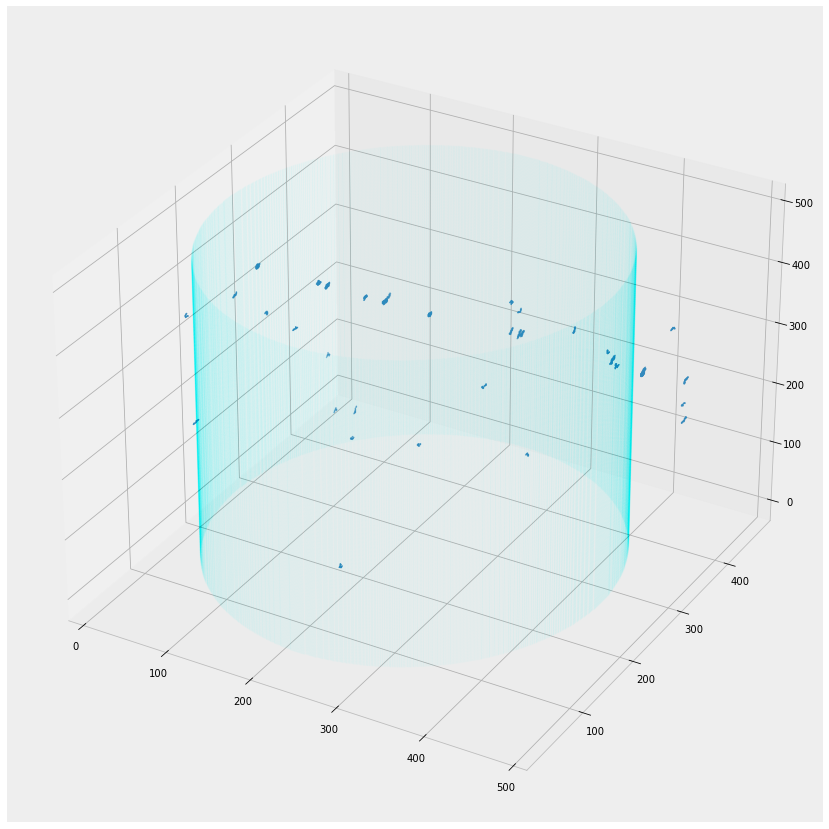

In [1252]:
# seems the contours are much smaller. Good!
# let's reshape and draw in 3d:
fig = plt.figure(figsize =(15, 15)) 
ax = plt.axes(projection ='3d') 
for zs in range(len(pores_high_res)):
    ax.scatter3D(contour[:, 0].reshape(-1), contour[:, 1].reshape(-1), zs=zs, s=1, alpha=.01, color='cyan')

ax.scatter(x, y, z, s=1)

In [80]:
# why is there a pore outside the boundary?
# let's see x, y, and z boundaries

In [85]:
print('pore x:', x.min(), x.max())
print('pore y:', y.min(), y.max())
print('pore z:', z.min(), z.max())
print('contour x and y:', contour.min(axis=0), contour.max(axis=0))

pore x: 20 481
pore y: 81 430
pore z: 97 389
contour x and y: [16 24] [454 462]


In [86]:
# I see x values do not fall within bounds! why?
# Anyways, let's rotate the image

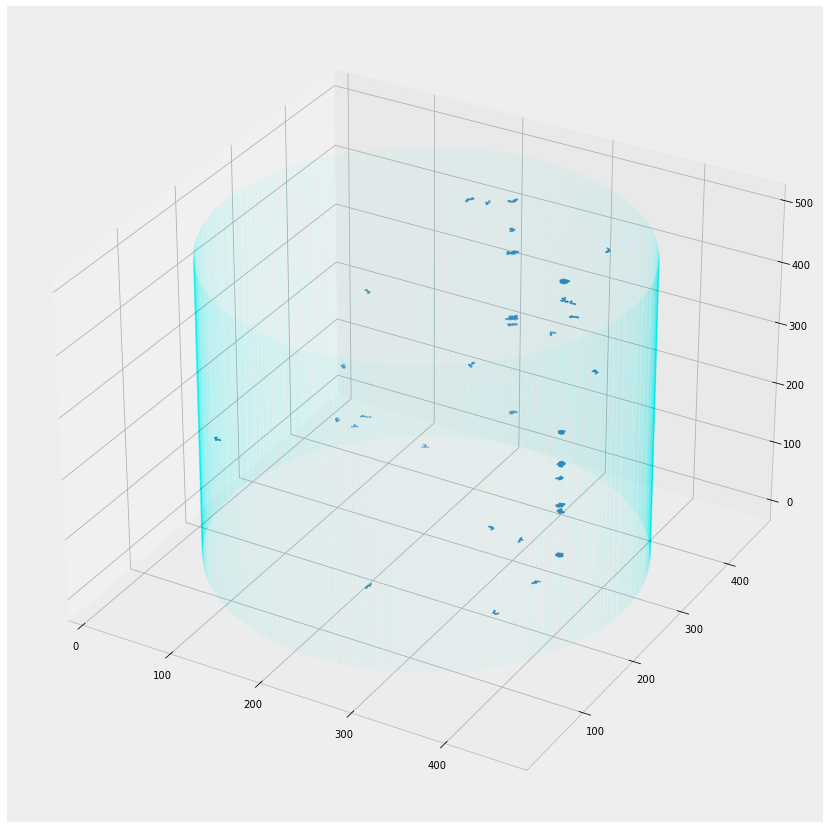

In [93]:
# seems the contours are much smaller. Good!
# let's reshape and draw in 3d:
fig = plt.figure(figsize =(15, 15)) 
ax = plt.axes(projection ='3d') 
for zs in range(len(pores_high_res)):
    ax.scatter3D(contour[:, 0].reshape(-1), contour[:, 1].reshape(-1), zs=zs, s=1, alpha=.01, color='cyan')

ax.scatter(z, y, x, s=1)

In [99]:
# from this, we can write a function to do this:
from additive2.utility import draw_pores

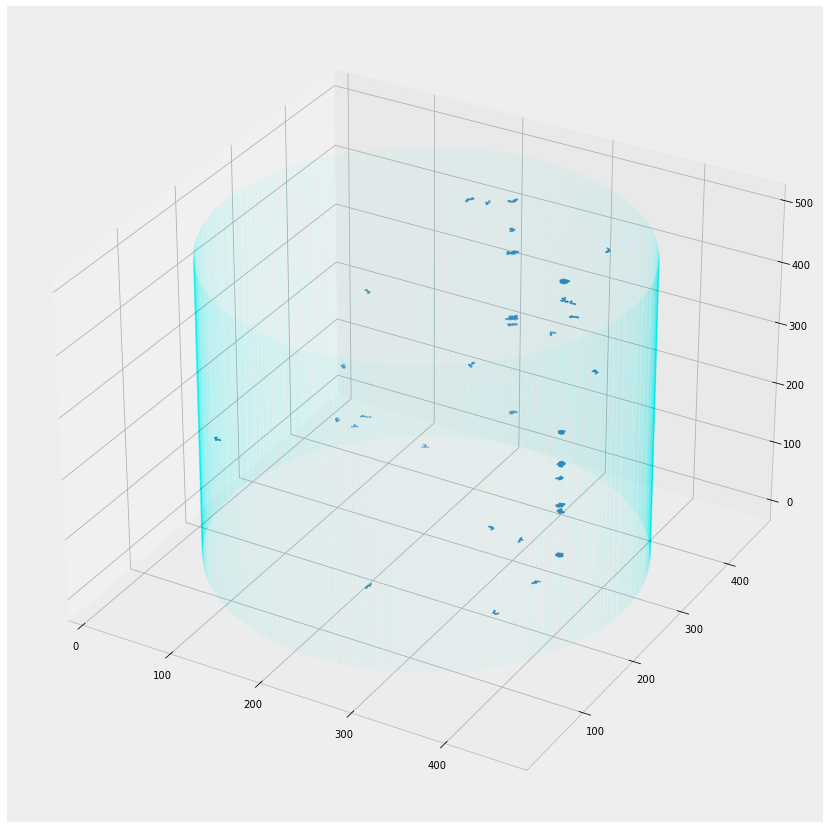

In [101]:
draw_pores(pores_mid_res, mask)

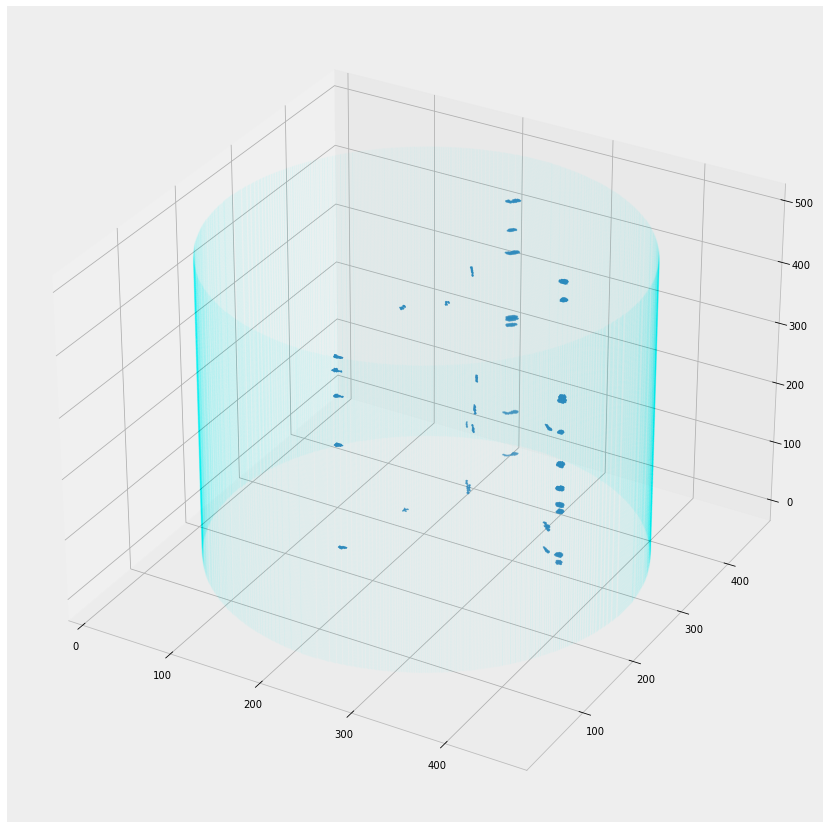

In [100]:
draw_pores(pores_high_res, mask)

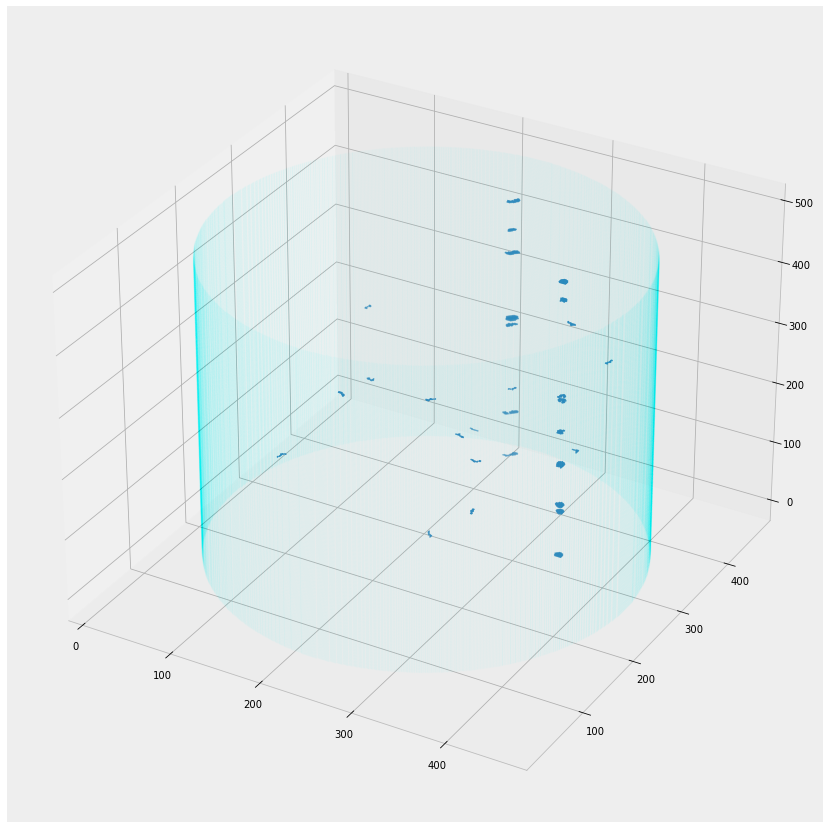

In [102]:
draw_pores(pores_pred, mask)

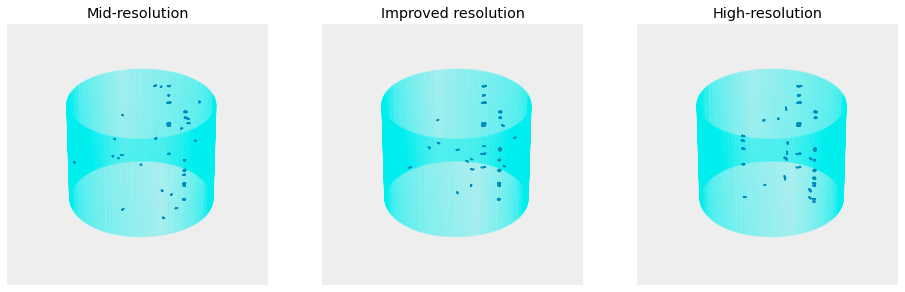

In [1257]:
# let's try to put the three in a single plot
fig = plt.figure(figsize=plt.figaspect(0.3))
axes = []
for i in range(1, 4):
    axes.append(fig.add_subplot(1, 3, i, projection='3d'))

titles = ['Mid-resolution', 'Improved resolution', 'High-resolution']
pore_imgs = [pores_mid_res, pores_pred, pores_high_res]


for ax, pore_img, title in zip(axes, pore_imgs, titles):
    draw_pores(pore_img, mask, ax=ax)
    ax.set_title(title)
    ax.axis('off')

## Pore count

In [136]:
# let's find a way to compute pairwise pixel distance

In [428]:
from scipy.spatial.distance import pdist

In [429]:
from additive2.utility import get_clusters

In [459]:
clusters_high_res, indices_high_res = get_clusters(pores_high_res)
clusters_mid_res, indices_mid_res = get_clusters(pores_mid_res)
clusters_pred, indices_predicted = get_clusters(pores_pred)

In [460]:
clusters_mid_res.max(), clusters_pred.max(), clusters_high_res.max()

(1389, 1864, 3012)

In [569]:
# idea: use graph theory packages
from additive2.utility import get_eligible_dists, get_pores
import igraph as gp

In [773]:
clusters_mid, pts_mid, clusters_mid_ = get_pores(pores_mid_res, are_pts=False)

In [775]:
clusters_pred, pts_pred, clusters_pred_ = get_pores(pores_pred, are_pts=False)

In [777]:
clusters_high, pts_high, clusters_high_ = get_pores(pores_high_res, are_pts=False)

In [778]:
assert len(clusters_mid) == len(pts_mid)
assert len(clusters_high) == len(pts_high)
assert len(clusters_pred) == len(pts_pred)

In [1224]:
from additive2.utility import find_matching_pores, find_matching_clusters
pred_high_map, high_pred_map = find_matching_pores(pts_pred, pts_high)
mid_high_map, high_mid_map = find_matching_pores(pts_mid, pts_high)

In [1225]:
# the following should match pixel-wise comparisons above
(pred_high_map>-1).sum() / len(pred_high_map), (high_pred_map>-1).sum() / len(high_pred_map), (mid_high_map>-1).sum() / len(mid_high_map), (high_mid_map>-1).sum() / len(high_mid_map)

(0.7715996578272027, 0.527177089421391, 0.5581151832460733, 0.3115137346580947)

In [1237]:
# the following should match pixel-wise comparisons above
def get_precision_recall(mp1, mp2):
    tp = np.sum(mp1>-1)
    fp = np.sum(mp1==-1)
    fn = np.sum(mp2==-1)
    return tp/(tp+fp), (tp)/(tp+fn)
res = pd.DataFrame(
    [get_precision_recall(pred_high_map, high_pred_map), get_precision_recall(mid_high_map, high_mid_map)],
    columns = ['Precision', 'Recall']
)
res.index = ['Improved Resolution', 'Medium Resolution']
res['Accuracy'] = 1
res.round(2)

Precision  Recall  Accuracy
Improved Resolution       0.77    0.53         1
Medium Resolution         0.56    0.31         1

Which it does.

Now let's compare the three images based on the numbers of matching pores

In [781]:
cl_pred_high_map = find_matching_clusters(pred_high_map, clusters_pred, clusters_high)
cl_mid_high_map = find_matching_clusters(mid_high_map, clusters_mid, clusters_high)

In [782]:
# total number of matched pores between mid-res and high res
len(cl_mid_high_map)

14

In [783]:
# total number of matched pores between predicted and high res
len(cl_pred_high_map)
# let's say it is 25

18

In [784]:
# total number of pores detected by high-res is:
np.max(clusters_high)

38

let's check how individual pore sizes compare to each other

In [839]:
# comparing mid vs high pores sizes
from IPython.display import display
res = get_pore_size_diff(cl_mid_high_map, clusters_mid_, clusters_high_, name1='mid', name2='high')
display(res)
res['rel. error'].describe()

mid  high  rel. error
0    47    54        0.15
1    36    72        1.00
2    39    51        0.31
3    47    61        0.30
4    56    57        0.02
5    37    37        0.00
6    35    61        0.74
7    45    78        0.73
8    44    68        0.55
9    63    79        0.25
10   25    45        0.80
11   33    76        1.30
12   23    46        1.00
13   57    60        0.05

count    14.000000
mean      0.514286
std       0.419170
min       0.000000
25%       0.175000
50%       0.430000
75%       0.785000
max       1.300000
Name: rel. error, dtype: float64

In [840]:
res = get_pore_size_diff(cl_pred_high_map, clusters_pred_, clusters_high_, name1='pred', name2='high')
display(res)
res['rel. error'].describe()

pred  high  rel. error
0     52    55        0.06
1     56    54        0.04
2     66    72        0.09
3     53    51        0.04
4     63    61        0.03
5     37    43        0.16
6     56    57        0.02
7     39    37        0.05
8     50    61        0.22
9     73    78        0.07
10    67    68        0.01
11    42    61        0.45
12    28    81        1.89
13    75    79        0.05
14    36    45        0.25
15    63    76        0.21
16    38    46        0.21
17    55    60        0.09

count    18.000000
mean      0.218889
std       0.431903
min       0.010000
25%       0.042500
50%       0.080000
75%       0.210000
max       1.890000
Name: rel. error, dtype: float64

Getting pore features

In [945]:
# pts_mid
pts_ = pts_mid[np.array(clusters_mid) == 0]

In [1007]:
from additive2.utility import PoreFeatures

In [1008]:
pf = PoreFeatures(pts_)

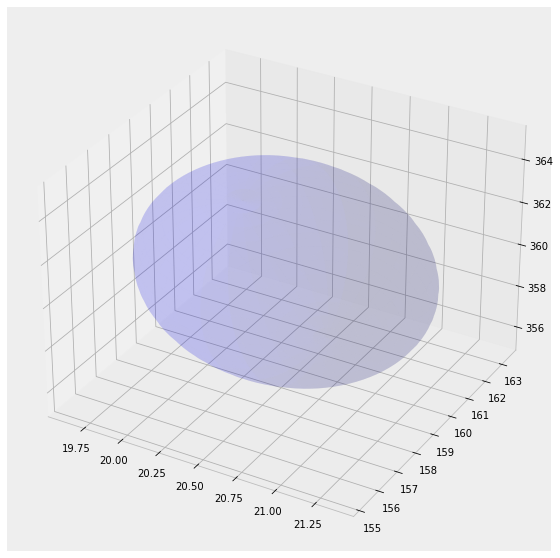

In [1009]:
et.plotEllipsoid(pf.ellipsoid)

In [1215]:
mid_features, high_features_mid = get_feature_pairs(cl_mid_high_map, pts_mid, clusters_mid, 
                                                    pts_high, clusters_high)
pred_features, high_features_pred = get_feature_pairs(cl_pred_high_map, pts_pred, clusters_pred, 
                                                 pts_high, clusters_high)

In [1216]:
from scipy.stats import ttest_1samp
ttest_1samp([1, 2, 3, 4, 5, 6], 0)

Ttest_1sampResult(statistic=4.58257569495584, pvalue=0.00593354451759226)

In [1217]:
def ttest_pvalue(x: pd.Series) -> float:
    return ttest_1samp(x, 0).pvalue

In [1222]:
stats_ = pd.DataFrame(
    (high_features_pred.values - pred_features.values),
    columns=pred_features.columns
).assign(tmp=1).groupby('tmp').agg(['mean', 'count', 'std', ttest_pvalue]).T.reset_index()
stats = pd.pivot_table(stats_, index='level_0', columns='level_1', values=1).drop('cluster')
ci95_hi = []
ci95_lo = []
for i in stats.index:
    m, c, s, *_ = stats[['mean', 'count', 'std']].loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_lo'] = ci95_lo
stats['ci95_hi'] = ci95_hi
display(stats.round(2).sort_index())

level_1               count   mean    std  ttest_pvalue  ci95_lo  ci95_hi
level_0                                                                  
Convex Hull Area       18.0   8.58  18.07          0.06     0.23    16.92
Convex Hull Volume     18.0   6.38  17.03          0.13    -1.49    14.25
Ellipsoid Area         18.0   8.47  25.25          0.17    -3.20    20.14
Ellipsoid Elongation   18.0  -0.05   0.84          0.82    -0.44     0.34
Ellipsoid Volume       18.0  10.46  35.26          0.23    -5.83    26.75
Pore Elongation        18.0   0.03   0.94          0.89    -0.40     0.47
Pore Sphericity        18.0   0.00   0.04          0.59    -0.01     0.02
Pore Volume            18.0  12.72  23.33          0.03     1.94    23.50

In [1223]:
stats_ = pd.DataFrame(
    (high_features_mid.values - mid_features.values),
    columns=mid_features.columns
).assign(tmp=1).groupby('tmp').agg(['mean', 'count', 'std', ttest_pvalue]).T.reset_index()
stats = pd.pivot_table(stats_, index='level_0', columns='level_1', values=1).drop('cluster')
ci95_hi = []
ci95_lo = []
for i in stats.index:
    m, c, s, *_ = stats[['mean', 'count', 'std']].loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

stats['ci95_lo'] = ci95_lo
stats['ci95_hi'] = ci95_hi
display(stats.round(2).sort_index())

level_1               count   mean    std  ttest_pvalue  ci95_lo  ci95_hi
level_0                                                                  
Convex Hull Area       14.0  32.91  39.55          0.01    12.20    53.63
Convex Hull Volume     14.0  14.86  17.65          0.01     5.61    24.10
Ellipsoid Area         14.0  37.26  60.40          0.04     5.62    68.90
Ellipsoid Elongation   14.0   1.02   1.67          0.04     0.15     1.90
Ellipsoid Volume       14.0  21.08  34.09          0.04     3.22    38.93
Pore Elongation        14.0   1.36   1.70          0.01     0.47     2.25
Pore Sphericity        14.0  -0.02   0.03          0.01    -0.04    -0.01
Pore Volume            14.0  38.14  32.31          0.00    21.22    55.07

In [1260]:
# todo write about the model